In [95]:
import numpy as np
import matplotlib.pyplot as plt
import epidemic_model_classes_numba as epi_mod
from data_loading import LoadData 
from proj_consts import ProjectConsts
import pandas as pd
from PIL import Image
import time
import os

log_paths = ["../logs/sdumont/log2021-06-10_15-31-22_adaptive_DF_SEIRD_3_posts_10_day-window_past_True/",
             "../logs/sdumont/log2021-06-10_16-29-54_adaptive_DF_SEIRD_3_posts_20_day-window_past_True/",
             "../logs/sdumont/log2021-06-10_17-19-07_adaptive_DF_SEIRD_3_posts_30_day-window_past_True/", 
             "../logs/sdumont/log2021-06-10_18-10-00_adaptive_DF_SEIRD_3_posts_40_day-window_past_True/", 
             "../logs/sdumont/log2021-06-10_19-02-36_adaptive_DF_SEIRD_3_posts_50_day-window_past_True/"]
log_labels = ["10", "20", "30", "40", "50"]

# data_path = open("data_path.txt", "r").read()
# df_brazil_state_cases = pd.read_csv(data_path)

# pop_state_dat = open(f"{ProjectConsts.DATA_PATH}/pop_states.csv", "r").read().split("\n")
# pop_state = {}
# for i in range(len(pop_state_dat)-1):
#     pop_state_dat[i] = pop_state_dat[i].split(", ")
#     pop_state[pop_state_dat[i][0]] = int(pop_state_dat[i][1])

In [96]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD']


In [97]:
# data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])

In [98]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

3


In [99]:
location = locations[0].split(" ")[0]

days_sets = sorted(os.listdir(log_paths[-1]+"Posterior1/%s/%s/"%(location, models[0])), key=lambda x: int(x.split("_")[0]))[:-3]
n_days = len(days_sets)

days = []

for days_set in days_sets:
    
    days.append(int(days_set.split("_")[0]))

days = np.array(days)

In [100]:
days

array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175,
       180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240,
       245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305,
       310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370,
       375, 380, 385, 390, 395, 400, 405, 410, 415, 420])

In [111]:
rmsd_train = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_val= [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_total = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]

trials = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
post_size = np.zeros((len(models), len(log_paths), n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(log_paths)):
        
        params.append(np.zeros((n_days, model.nparams)))
        
        path = log_paths[i]+"Posterior%i/%s/%s/" % (1, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):

            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]

            for line in range(len(log_file)):

                if "Training window size:" in log_file[line]:
                    post_size[model_idx, i, days_idx] = np.int(log_file[line].split(" ")[-1])
        
        path = log_paths[i]+"Posterior%i/%s/%s/" % (n_post, location, models[model_idx])

        for days_idx in range(len(days_sets)):

            params[-1][days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")

            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]

            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line

                if ("Number of trials" in log_file[line]):

                    trials[i][model_idx, days_idx] = int(log_file[line].split(" ")[-1])

            rmsd_train[i][model_idx, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[i][model_idx, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[i][model_idx, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

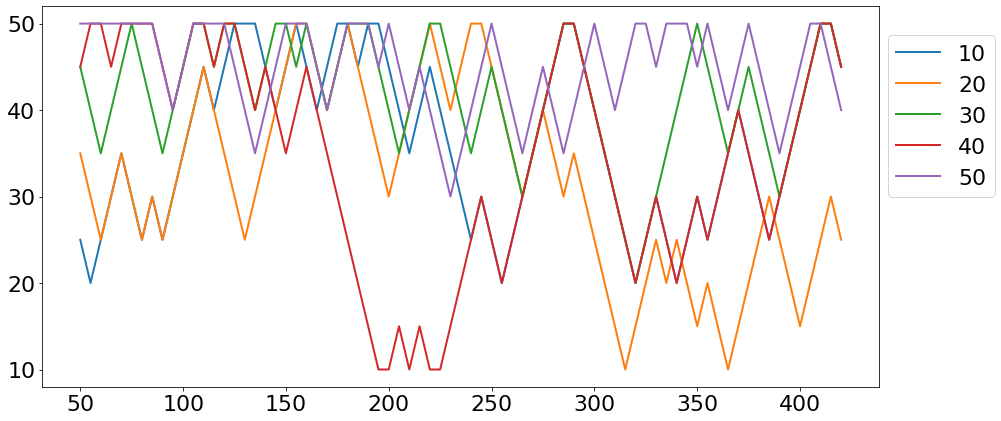

In [128]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.plot(days, post_size[0,i], lw=2, label=str((i+1)*10))
plt.legend(loc=(1.01, 0.5))

In [102]:
plt.rcParams.update({'font.size': 22})

def best_rows_cols(n):
    
    rows = 1
    cols = 1
    
    while (rows*cols < n):
        
        if (rows == cols):
            
            cols += 1
            
        else:
            
            rows += 1
            
    return np.array([rows, cols])

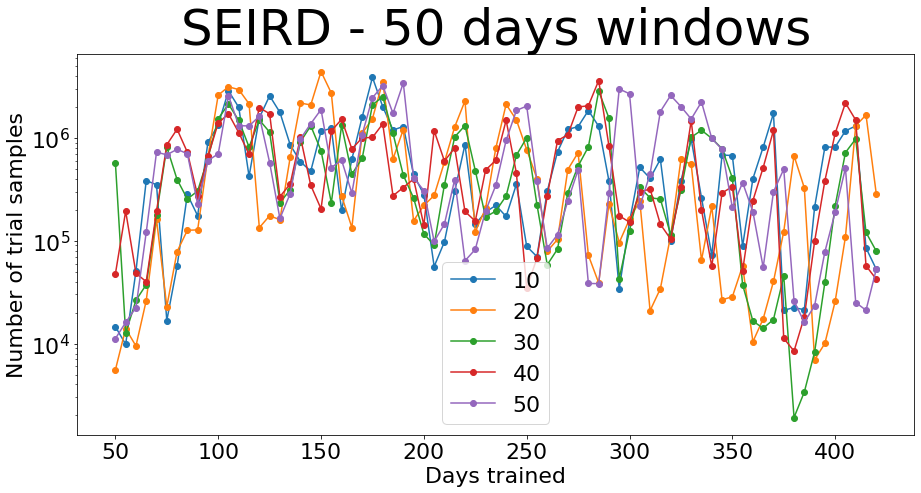

In [103]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,7))
        
    for j in range(len(trials)):
            
        plt.plot(days, trials[j][model_idx], "-o", label=log_labels[j])
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel("Number of trial samples")
        plt.yscale("log")
        plt.title(model.plot_name+" - 50 days windows", fontsize=50)
            
    plt.show()

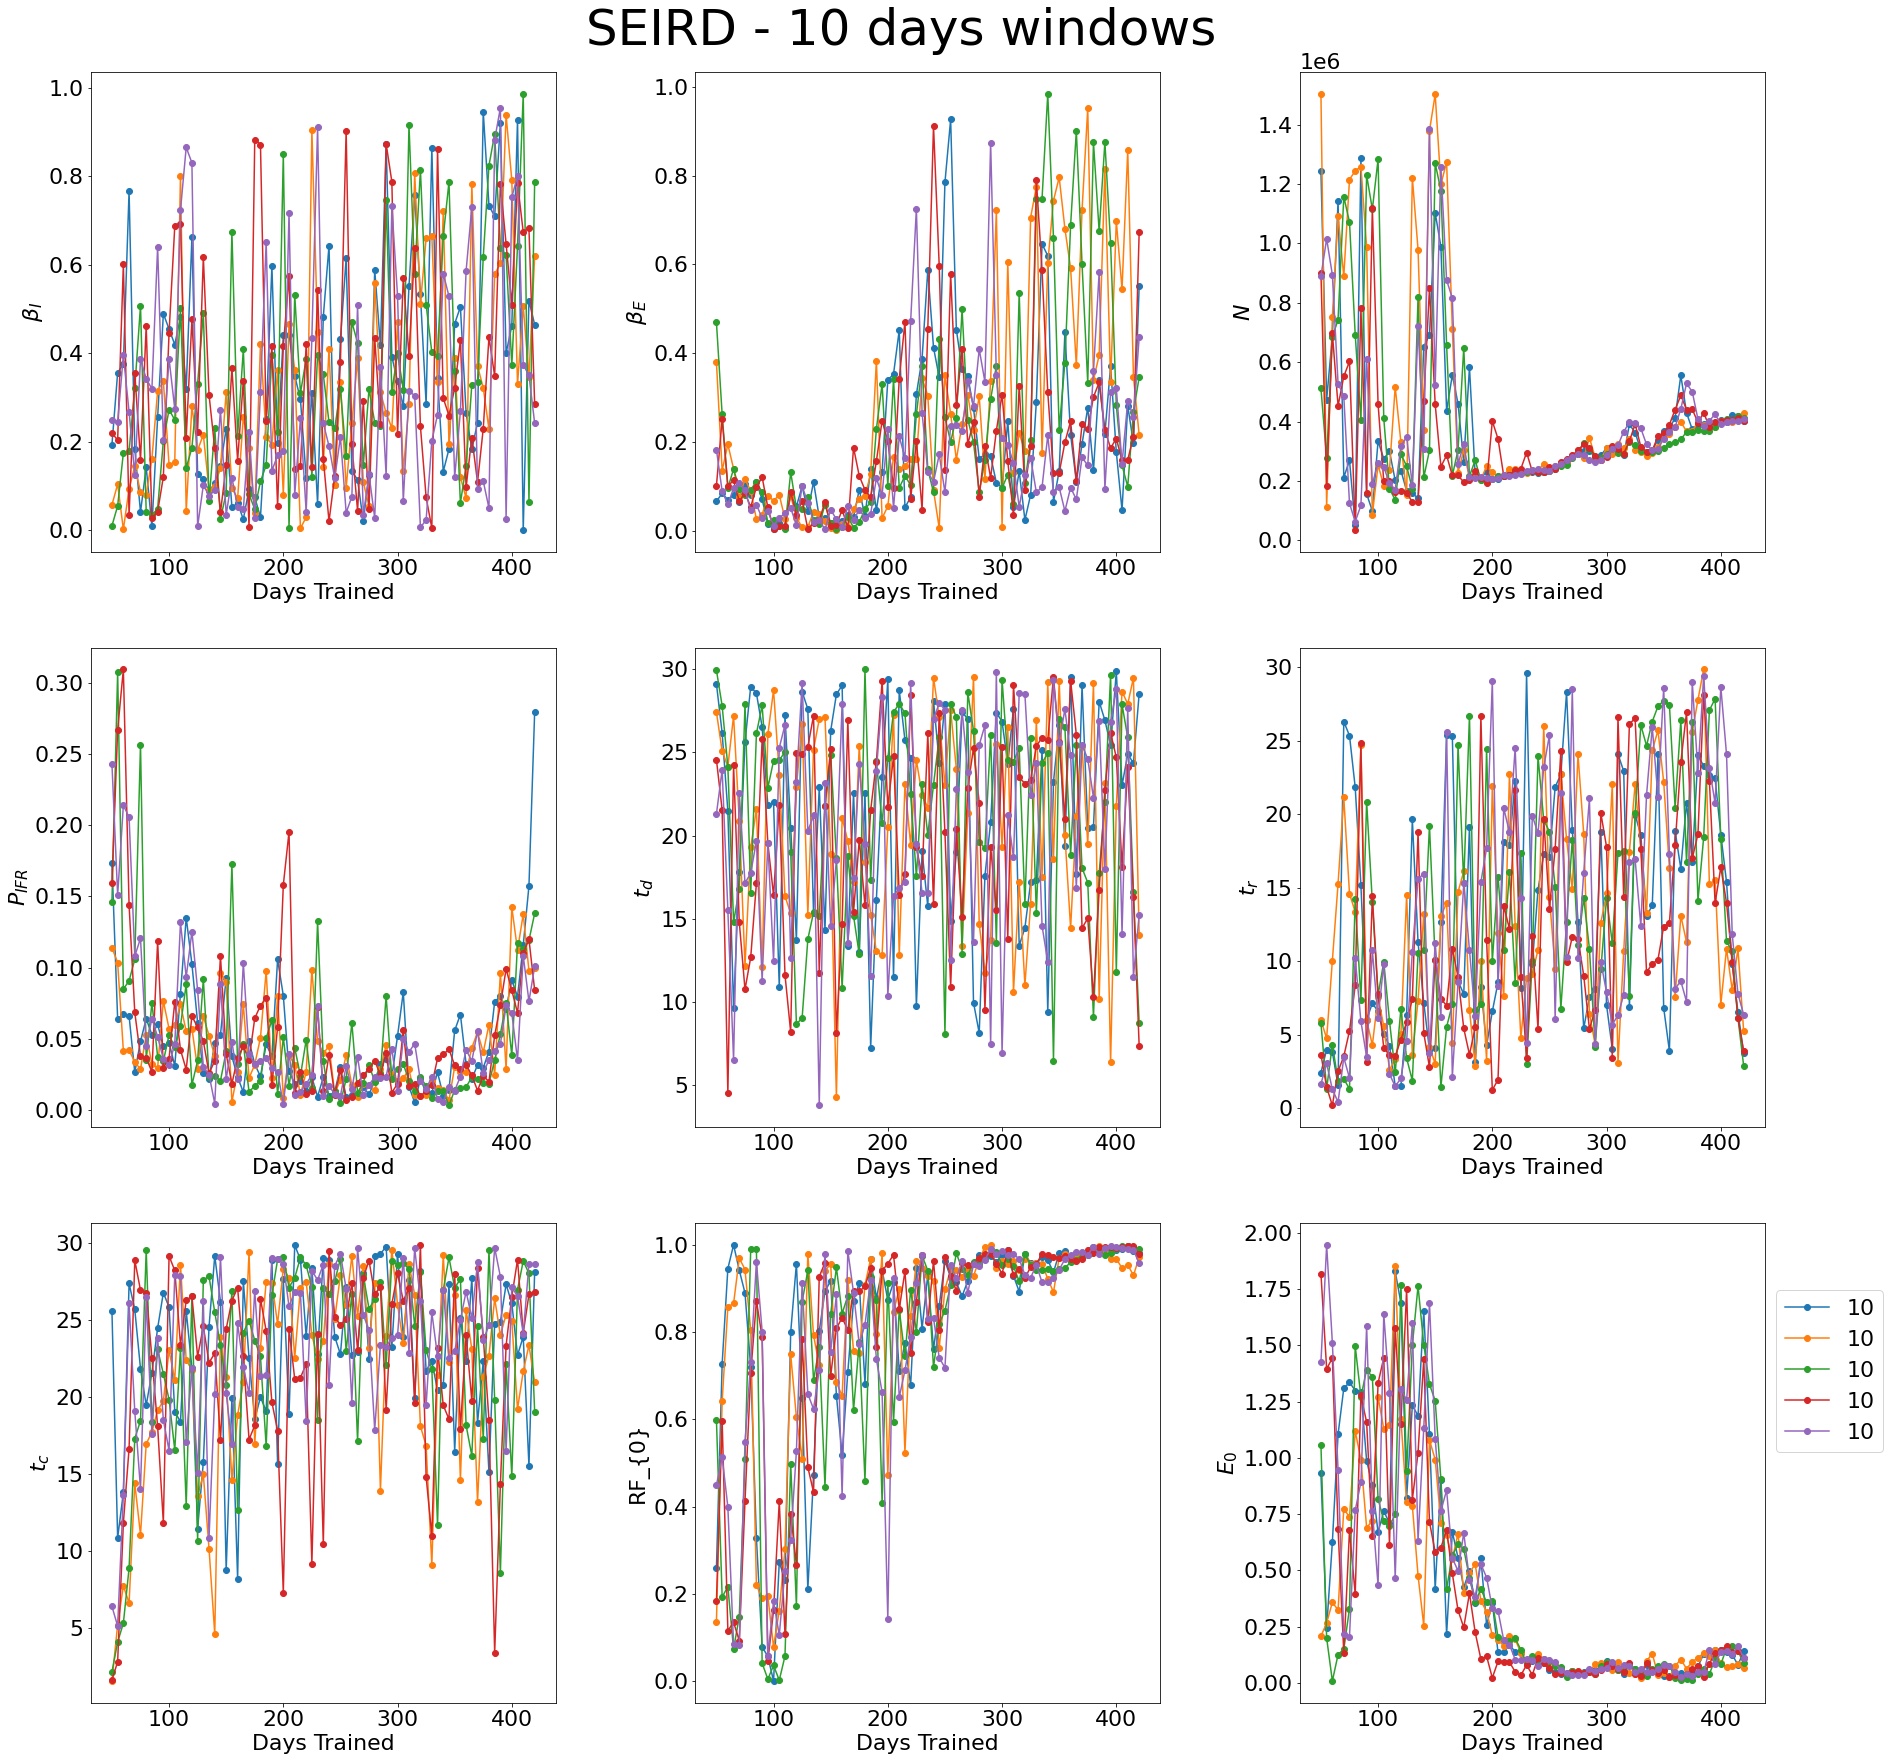

In [104]:
for j in range(len(models)):
    
    model = getattr(epi_mod, models[j])
    
    plt.figure(figsize=(10*best_rows_cols(params[0].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)

    for i in range(params[0].shape[-1]):

        plt.subplot(*best_rows_cols(params[0].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
#         for j in range(params[p].shape[0]):
        for p in range(len(params)):
            plt.plot(days, params[p][:,i], "-o", label=log_labels[j])
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):

            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")

    plt.suptitle(model.plot_name+" - 10 days windows", fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

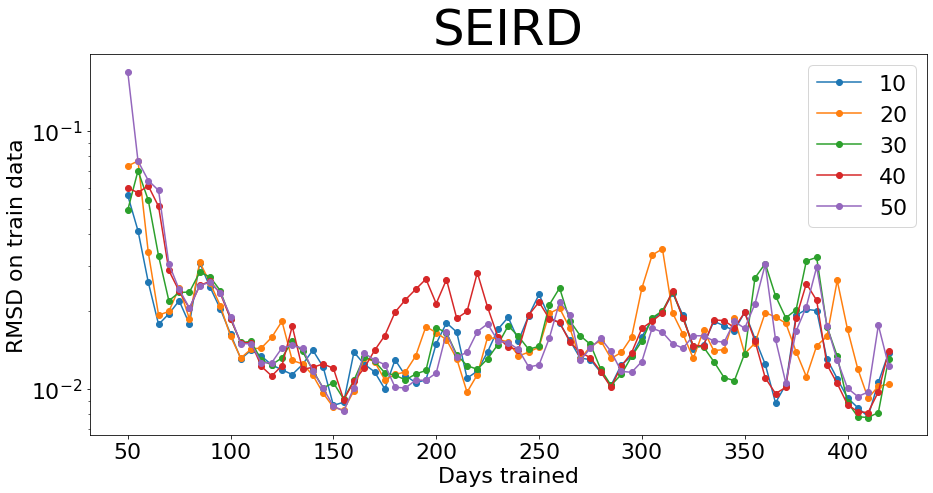

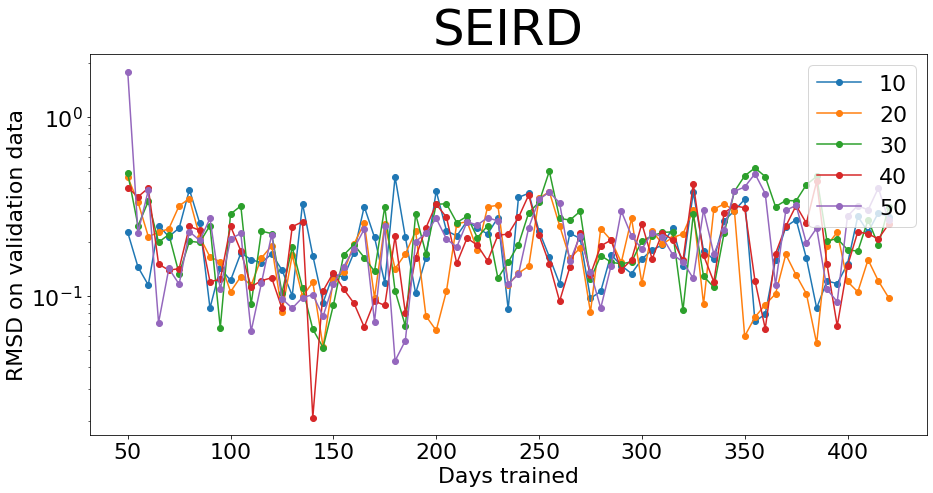

In [105]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)-1):
        
        plt.figure(figsize=(15,7))
        
        for j in range(len(rmsd[i])):
            
            plt.plot(days, rmsd[i][j][model_idx], "-o", label=log_labels[j])
            plt.legend(loc="upper right")
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.yscale("log")
            plt.title(model.plot_name, fontsize=50)
            
    plt.show()

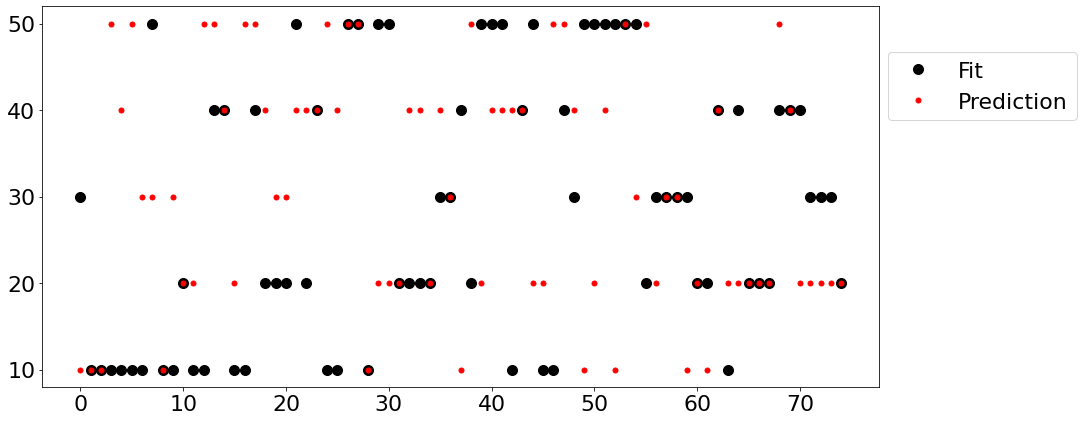

[19, 17, 11, 12, 16]
[10, 23, 9, 18, 15]


In [106]:
rmsd_train_ = np.concatenate(rmsd_train)
rmsd_train_min = np.zeros(rmsd_train_.shape[1])
for i in range(len(rmsd_train_min)):
    rmsd_train_min[i] = (np.where(rmsd_train_[:,i] == np.min(rmsd_train_[:,i]))[0][0]+1)*10

rmsd_val_ = np.concatenate(rmsd_val)
rmsd_val_min = np.zeros(rmsd_val_.shape[1])
for i in range(len(rmsd_val_min)):
    rmsd_val_min[i] = (np.where(rmsd_val_[:,i] == np.min(rmsd_val_[:,i]))[0][0]+1)*10

plt.figure(figsize=(15, 7))
plt.plot(rmsd_train_min, "o", c="k", ms=10, alpha=1, label="Fit")
plt.plot(rmsd_val_min, "o", c="r", ms=5, alpha=1, label="Prediction")
plt.legend(loc=(1.01, 0.7))
plt.show()

train_count = [np.sum(rmsd_train_min==i) for i in [10, 20, 30, 40, 50]]
print(train_count)
val_count = [np.sum(rmsd_val_min==i) for i in [10, 20, 30, 40, 50]]
print(val_count)

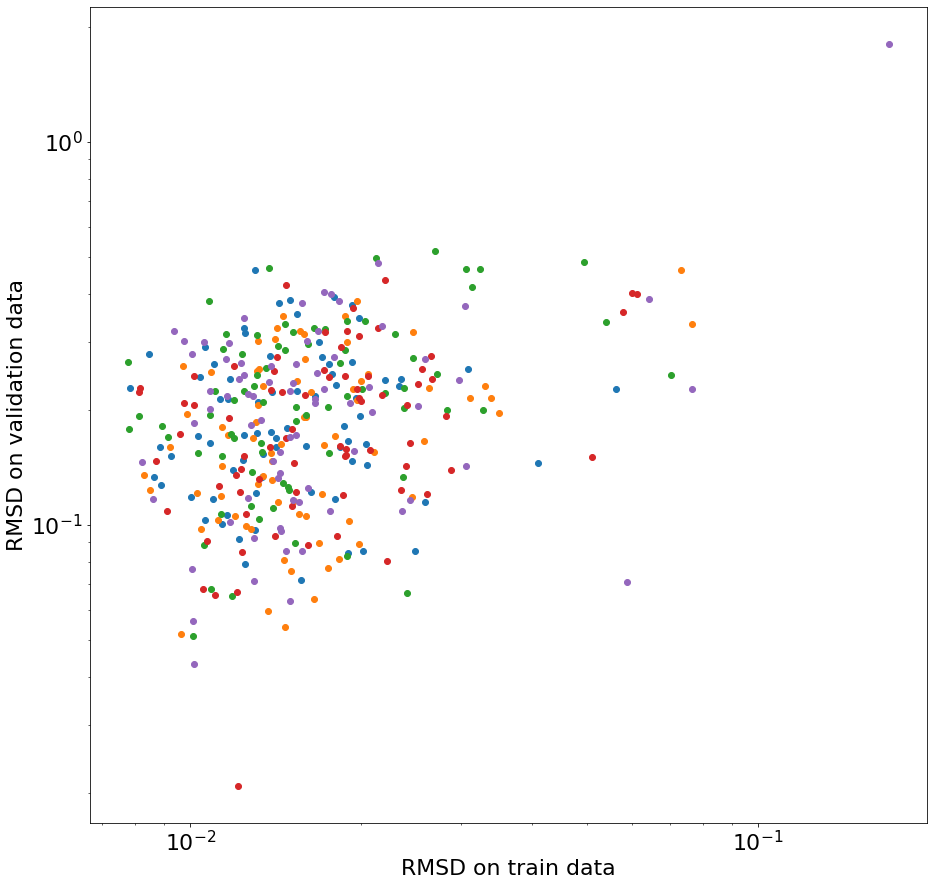

In [107]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,15))
    
    xx = np.linspace(min(np.min(rmsd[0]), np.min(rmsd[1])), min(np.min(rmsd[0]), np.min(rmsd[1])), 2)
    
    for j in range(len(rmsd[0])):
        
        plt.plot(rmsd[0][j].flatten(), rmsd[1][j].flatten(), "o", label="Posterior %i"%(j+1))
#         plt.legend()
        plt.xlabel(rmsd_names[0])
        plt.ylabel(rmsd_names[1])
        plt.xscale("log")
        plt.yscale("log")
#         plt.title(model.plot_name, fontsize=50)
    plt.show()

In [108]:
from scipy.stats import pearsonr

for j in range(len(log_paths)):
    print("--- ", log_labels[j], " ---")
    print("RMSD on train and validation Pearson Correlations:")
    print("Posterior %i:"%(i+1), pearsonr(rmsd[0][j].flatten(), rmsd[1][j].flatten()))
    print()

---  10  ---
RMSD on train and validation Pearson Correlations:
Posterior 75: (0.04181893085107331, 0.7216641291103614)

---  20  ---
RMSD on train and validation Pearson Correlations:
Posterior 75: (0.4387497350427616, 8.234052325278542e-05)

---  30  ---
RMSD on train and validation Pearson Correlations:
Posterior 75: (0.38187859901526283, 0.0007229766409357262)

---  40  ---
RMSD on train and validation Pearson Correlations:
Posterior 75: (0.4375982173736954, 8.638245202042673e-05)

---  50  ---
RMSD on train and validation Pearson Correlations:
Posterior 75: (0.7758320984941838, 2.98106900961202e-16)

